<a href="https://colab.research.google.com/github/vrathi101/NSDI-Inclusivity/blob/main/NSDIConference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and import necessary Python libraries for subsequent code (these libraries will be used throughout the Google Colabs.
1. Fuzzywuzzy is used for string matching (comparing strings which aren't identical but may have differences caused by typos, abbreviations, etc.). I used this when there weren't exact matches between the committee member dataframe and the researchers csv.
2. Levenshtein is used to measure the "distance" between strings which will be used for fuzzy comparing.
3. Beautifulsoup4 is used for webscraping. I used webscraping to extract the committee members for each year for SIGCOMM.
4. Gender-guesser is used to guess the gender of a person based on their first name. It have 6 possible outputs: 'male', 'mostly_male', 'female', 'mostly_female', 'andy', and 'unknown'. I used this for the names which had a fuzzy ratio of less than the fixed threshold when compared to every name in the researchers csv.

In [ ]:
#install all packages
!pip install fuzzywuzzy
!pip install levenshtein
!pip install requests beautifulsoup4
!pip install gender-guesser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 23.5 MB/s eta 0:00:00


Import all of the libraries we will be using.

In [ ]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import gender_guesser.detector as gender_detector
import re

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
proj_path = '/content/gdrive/MyDrive/Colab Notebooks/save_data/'

Mounted at /content/gdrive


Using webscraping to extract all the program committee and steering committee members and their institutions for NSDI from 2013-2023, inclusive, and then adding all the names/regions, categorized by year and committee type, into a dataframe.

In [ ]:
dfNSDI = pd.DataFrame(columns=['name', 'region', 'year', 'committee'])
committee = 'Program'

for year in range(2013, 2024):
  current_year = year % 100
  url = f"https://www.usenix.org/conference/nsdi{current_year}/call-for-papers"
  response = requests.get(url)
  soup = BeautifulSoup(response.text, "html.parser")

  program_committee_h3 = soup.find('h3', string='Program Committee')
  if program_committee_h3 is not None:
    name_divs = program_committee_h3.find_all_next('div')
    name_divs_filtered = []
    for div in name_divs:
      if div is not None:
        if div.find_previous_sibling('h3') == program_committee_h3:
          name_divs_filtered.append(div)
    for div in name_divs_filtered:
      name_div = div.find('div', class_='field-content').text.strip()
      if name_div is not None:
        name_text = name_div.strip()
        if ',' in name_text:
          name = name_text.split(',')[0].strip()
        region_tag = div.find('em')
        if region_tag is not None:
          region = region_tag.text.strip()
          name = name.replace(region_tag.text, '')
        else:
          region = None
        df = pd.DataFrame({'name': [name], 'region': [region], 'year': year, 'committee': committee})
        dfNSDI = pd.concat([dfNSDI, df], ignore_index=True)

dfNSDI = dfNSDI.reset_index(drop=True)
print(dfNSDI)

                  name                                            region  \
0        Aditya Akella                   University of Wisconsin—Madison   
1    Katerina Argyraki  École Polytechnique Fédérale de Lausanne  (EPFL)   
2       Suman Banerjee                   University of Wisconsin—Madison   
3       Matthew Caesar        University of Illinois at Urbana-Champaign   
4           Jeff Chase                                   Duke University   
..                 ...                                               ...   
569         Ennan Zhai                                           Alibaba   
570         Ying Zhang                                              Meta   
571           Ben Zhao                             University of Chicago   
572      Zhizhen Zhong             Massachusetts Institute of Technology   
573       Danyang Zhuo                                   Duke University   

     year committee  
0    2013   Program  
1    2013   Program  
2    2013   Program  

In [ ]:
committee = 'Steering'

for year in range(2013, 2024):
  current_year = year % 100
  url = f"https://www.usenix.org/conference/nsdi{current_year}/call-for-papers"
  response = requests.get(url)
  soup = BeautifulSoup(response.text, "html.parser")

  program_committee_h3 = soup.find('h3', string='Steering Committee')
  if program_committee_h3 is not None:
    name_divs = program_committee_h3.find_all_next('div')
    name_divs_filtered = []
    for div in name_divs:
      if div is not None:
        if div.find_previous_sibling('h3') == program_committee_h3:
          name_divs_filtered.append(div)
    for div in name_divs_filtered:
      name_div = div.find('div', class_='field-content').text.strip()
      if name_div is not None:
        name_text = name_div.strip()
        if ',' in name_text:
          name = name_text.split(',')[0].strip()
        region_tag = div.find('em')
        if region_tag is not None:
          region = region_tag.text.strip()
          name = name.replace(region_tag.text, '')
        else:
          region = None
        df = pd.DataFrame({'name': [name], 'region': [region], 'year': year, 'committee': committee})
        dfNSDI = pd.concat([dfNSDI, df], ignore_index=True)

dfNSDI = dfNSDI.reset_index(drop=True)
# Print the final DataFrame
print(dfNSDI.head(5))
print(len(dfNSDI))
print(dfNSDI.groupby(['year', 'committee'])['year', 'committee'].count())

                name                                            region  year  \
0      Aditya Akella                   University of Wisconsin—Madison  2013   
1  Katerina Argyraki  École Polytechnique Fédérale de Lausanne  (EPFL)  2013   
2     Suman Banerjee                   University of Wisconsin—Madison  2013   
3     Matthew Caesar        University of Illinois at Urbana-Champaign  2013   
4         Jeff Chase                                   Duke University  2013   

  committee  
0   Program  
1   Program  
2   Program  
3   Program  
4   Program  
688
                year  committee
year committee                 
2013 Program      30         30
     Steering      7          7
2014 Program      32         32
     Steering      7          7
2015 Program      43         43
     Steering      7          7
2016 Program      40         40
     Steering      7          7
2017 Program      42         42
     Steering      9          9
2018 Program      43         43
     Steering  

<ipython-input-5-aa5a3ef31f11>:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(dfNSDI.groupby(['year', 'committee'])['year', 'committee'].count())


Polishing the dataframe to make matching easier.

In [ ]:
dfNSDI['name']=dfNSDI['name'].str.replace('\xa0', ' ')

In [ ]:
updates1 = [
    (512, 'Rebecca Isaacs', 'Amazon'),
    (593, 'Mike Schroeder', 'Microsoft Research')
]
for index, new_name, new_region in updates1:
  dfNSDI.at[index, 'name'] = new_name
  dfNSDI.at[index, 'region'] = new_region

dfNSDI = dfNSDI.reset_index(drop=True)
updates2 = [
    (7, 'Mike Freedman'),
    (25, 'Lakshminarayanan Subramanian'),
    (97, 'Lakshminarayanan Subramanian'),
    (80, 'Kimberly Keeton'),
    (128, 'Kate Ching-Ju Lin'),
    (146, 'Thomas E. Anderson'),
    (167, 'Jay Lorch'),
    (170, 'David Maltz'),
    (226, 'Timothy Wood 0001'),
    (315, 'Jitendra Padhye'),
    (355, 'Matthew Caesar 0001'),
    (378,'Changhoon Kim'),
    (543,'Jennifer Rexford'),
    (553, 'Dimitrios Skarlatos 0002'),
]
for index, new_name in updates2:
  dfNSDI.at[index, 'name'] = new_name

In [ ]:
# Grouping the dataframe by year and committee
grouped = dfNSDI.groupby(['year', 'committee'])

# Checking for duplicate names within each group
duplicates = grouped['name'].apply(lambda x: x[x.duplicated()])

if duplicates.empty:
    print("No duplicates exist.")
else:
    print("Duplicate names found:")
    for duplicate in duplicates:
        print(duplicate)

No duplicates exist.


Writing the current dataframe to Google Drive as a CSV to read as we go on.

In [ ]:
dfNSDI.to_csv("/content/gdrive/My Drive/Colab Notebooks/save_data/NSDINames.csv", sep=',', index=False, encoding='utf-8')

Reading both the NSDI dataframe and the manually-curated researcher data dataframe and making some adjustments.

In [ ]:
dfNSDI = pd.read_csv(proj_path + 'NSDINames.csv')
dfResearchers = pd.read_csv(proj_path + 'researcher.csv')
# Specify the columns to extract from the 'researchers' DataFrame
columns_to_extract =['Name','Female or NB', 'Region']
# Create a new DataFrame 'dfResearcher' with the selected columns
dfResearcher = dfResearchers[columns_to_extract]
dfResearcher.rename(columns={'Female or NB': 'Gender'}, inplace=True)
dfResearcher['Gender'] = dfResearcher['Gender'].replace({float('Nan'): 'Male', 1.0: 'Female'})
dfResearcher['Region'].fillna('NorAm', inplace=True)
dfResearcher.drop_duplicates(subset = 'Name', inplace=True)
for column in dfResearcher.columns:
  dfResearcher[column] = dfResearcher[column].str.strip()
print(dfResearcher.head())
print(len(dfResearcher))

              Name  Gender Region
0  Sergey Gorinsky    Male     EU
1   Hitesh Ballani    Male     EU
2     Haya Shulman  Female     EU
3  Rüdiger Birkner    Male     EU
4     Klaus Wehrle    Male     EU
934


<ipython-input-10-500fddd3177a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfResearcher.rename(columns={'Female or NB': 'Gender'}, inplace=True)
<ipython-input-10-500fddd3177a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfResearcher['Gender'] = dfResearcher['Gender'].replace({float('Nan'): 'Male', 1.0: 'Female'})
<ipython-input-10-500fddd3177a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Adding columns to dfNSDI (original) dataframe by comparing it with dfResearcher dataframe based on the full name of a committee member and a fuzzy match. Another column is used for the gender-guesser library which guesses the gender for every NSDI member in dfNSDI.
Additionally, for all the committee members whose continent of location could not be determined, it will check if the dfResearcher has these names with their regions and add it in accordingly.

In [ ]:
#add a DirectMatch column which puts in gender if found in dfResearcher based on code
dfNSDI['DirectMatch'] = ''
for index, row in dfNSDI.iterrows():
  chkName=row['name'].strip()
  gender=''
  if (chkName in dfResearcher['Name'].values):
    first_location  = dfResearcher.loc[dfResearcher['Name'] == chkName].index[0]
    gender = dfResearcher.loc[first_location, 'Gender']
    dfNSDI.at[index, 'DirectMatch'] = gender
print(dfNSDI.groupby(['DirectMatch'])['DirectMatch'].count())

#add a FuzzyMatch column which puts in gender if found in dfResearcher based on code
dfNSDI['FuzzyMatch'] = ''
dfNSDI['Continent'] = ''
for idx, row in dfNSDI.iterrows():
    name_updated = row['name']
    #region_updated = row['region']
    continent = row['Continent']
    best_match = None
    best_score = 0
    researcher_row = None
    for _, research_row in dfResearcher.iterrows():
        name_research = research_row['Name']
        score = fuzz.token_set_ratio(name_updated, name_research)
        if score > best_score and score > 90:
            best_match = research_row['Gender']
            best_score = score
            researcher_row = research_row
        if score == 100:  # If perfect match, break the loop
            break
    dfNSDI.loc[idx, 'FuzzyMatch'] = best_match
    if continent.strip()=='' and researcher_row is not None:
      dfNSDI.loc[idx, 'Continent'] = researcher_row['Region']
print(dfNSDI.groupby(['FuzzyMatch'])['FuzzyMatch'].count())

#add a GenderGuesser column which puts in gender if found in dfResearcher based on code
dfNSDI['GenderGuesser']=''
def guess_gender(first_name):
    # Initialize gender detector
    d = gender_detector.Detector()
    # Get the gender of the first name
    gender = d.get_gender(first_name)
    return gender
for idx, row in dfNSDI.iterrows():
  Name = row['name']
  gender=guess_gender(Name.split()[0])
  dfNSDI.loc[idx, 'GenderGuesser'] = gender
print(dfNSDI.groupby(['GenderGuesser'])['GenderGuesser'].count())

DirectMatch
           73
Female    133
Male      482
Name: DirectMatch, dtype: int64
FuzzyMatch
Female    156
Male      532
Name: FuzzyMatch, dtype: int64
GenderGuesser
andy              25
female           107
male             357
mostly_female     11
mostly_male       14
unknown          174
Name: GenderGuesser, dtype: int64


Wriitng the current dataframe to a CSV and reading it again as we go on.

In [ ]:
dfNSDI.to_csv("/content/gdrive/My Drive/Colab Notebooks/save_data/NSDINamesAdjusted.csv", sep=',', index=False, encoding='utf-8')

In [ ]:
dfNSDI = pd.read_csv(proj_path + 'NSDINamesAdjusted.csv')

Changing the names of the values in the 'Continent' column to their full names. This will be used in the graphs at the end.

In [ ]:
continent_mapping = {
    'NorAm': 'North America',
    'AS': 'Asia',
    'Asia': 'Asia',
    'OC': 'Australia',
    'Australia': 'Australia',
    'SA': 'South America',
    'Africa': 'Africa',
    'AF': 'Africa',
    'EU': 'Europe'
}
dfNSDI['Continent'] = dfNSDI['Continent'].replace(continent_mapping)

Filling in the dataframe Gender column based on the columns DirectMatch, FuzzyMatching, and GenderGuesser which receive priority in the order listed.

In [ ]:
#create an empty Gender column
dfNSDI['Gender']=''

#GenderFullNameMatch checked first
dfNSDI['Gender'] = dfNSDI['Gender'].replace('', np.nan)
dfNSDI['Gender'] = dfNSDI['Gender'].fillna(dfNSDI['DirectMatch'])

#FuzzyMatching checked second
dfNSDI['Gender'] = dfNSDI['Gender'].fillna(dfNSDI['FuzzyMatch'])

#GenderPython checked third
#dfNSDI['Gender'] = dfNSDI['Gender'].fillna(np.nan)
dfNSDI['Gender'] = dfNSDI['Gender'].fillna(dfNSDI['GenderGuesser'])
dfNSDI['Gender'] = dfNSDI['Gender'].replace(['male', 'mostly_male'], 'Male')
dfNSDI['Gender'] = dfNSDI['Gender'].replace(['female', 'mostly_female'], 'Female')
dfNSDI['Gender'] = dfNSDI['Gender'].replace(['andy', 'unknown'], 'Unknown')

Determining the method used to find gender based on which columns had empty values vs. non-empty values.

In [ ]:
dfNSDI['Source'] = ''
for index, row in dfNSDI.iterrows():
  # if column A is nonempty, fill in Source (method) with column A method name
  if not pd.isnull(row['DirectMatch']):
    dfNSDI.loc[index, 'Source'] = 'FullNameMatch'
  # if column A is empty and column B is nonempty, fill in Source with column B method name
  elif pd.isnull(row['DirectMatch']) and pd.notna(row['FuzzyMatch']):
    dfNSDI.loc[index, 'Source'] = 'FuzzyMatch'
  # if column A is empty, column B is empty, fill in Source with column C method name
  else:
    dfNSDI.loc[index, 'Source'] = 'GenderGuesser'
pd.reset_option('display.max_rows')
dfNSDI.head(10)

,name,region,year,committee,DirectMatch,FuzzyMatch,Continent,GenderGuesser,Gender,Source
0,Aditya Akella,University of Wisconsin—Madison,2013,Program,Male,Male,North America,male,Male,FullNameMatch
1,Katerina Argyraki,École Polytechnique Fédérale de Lausanne (EPFL),2013,Program,NaN,Female,Europe,female,Female,FuzzyMatch
2,Suman Banerjee,University of Wisconsin—Madison,2013,Program,Male,Male,North America,mostly_female,Male,FullNameMatch
3,Matthew Caesar,University of Illinois at Urbana-Champaign,2013,Program,NaN,Male,North America,male,Male,FuzzyMatch
4,Jeff Chase,Duke University,2013,Program,Male,Male,North America,male,Male,FullNameMatch
5,Rodrigo Fonseca,Brown University,2013,Program,Male,Male,North America,male,Male,FullNameMatch
6,Bryan Ford,Yale University,2013,Program,Male,Male,North America,male,Male,FullNameMatch
7,Mike Freedman,Princeton University,2013,Program,Male,Male,North America,male,Male,FullNameMatch
8,Krishna Gummadi,Max Planck Institute for Software Systems (MPI...,2013,Program,NaN,Male,Europe,andy,Male,FuzzyMatch
9,Rebecca Isaacs,Microsoft Research,2013,Program,Female,Female,North America,female,Female,FullNameMatch


Again writing the current (final) dataframe to another CSV.

In [ ]:
dfNSDI.to_csv("/content/gdrive/My Drive/Colab Notebooks/save_data/NSDINamesFinal.csv", sep=',', index=False, encoding='utf-8')

Making graphs showing the changes of gender distribution (as a percentage and as a count) for each of the two committee types over the entire time span.

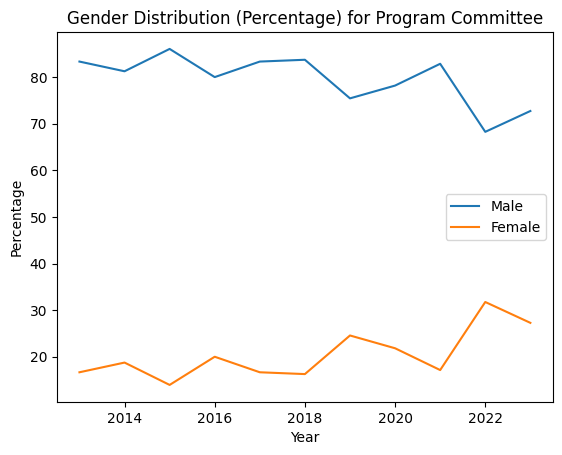

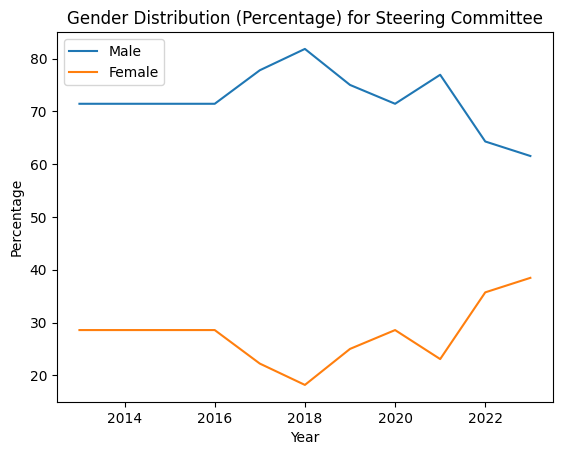

In [ ]:
# Get unique committee and year values from the DataFrame
committees = dfNSDI['committee'].unique()
years = dfNSDI['year'].unique()

# Get unique continent values from the "Continent" column
genders = dfNSDI['Gender'].unique()

# Create separate line graphs for each committee
for committee in committees:
    # Create a figure and axis for the current committee
    fig, ax = plt.subplots()

    # Loop through each continent
    for gender in genders:
        # Create an empty list to store the percentages for each year
        percentages = []

        # Loop through each year
        for year in years:
            # Filter the DataFrame for the current committee, continent, and year
            df_filtered = dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['Gender'] == gender) & (dfNSDI['year'] == year)]

            # Get the count of members for the current continent and year
            count = len(df_filtered)

            # Calculate the percentage by dividing the count by the total count for the committee and year
            total_count = len(dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['year'] == year)])
            percentage = (count / total_count) * 100

            # Append the percentage to the list
            percentages.append(percentage)

        # Plot the percentages as a line graph for the current continent
        ax.plot(years, percentages, label=gender)

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Gender Distribution (Percentage) for {committee} Committee')
    ax.legend()

    # Display the plot
    plt.show()

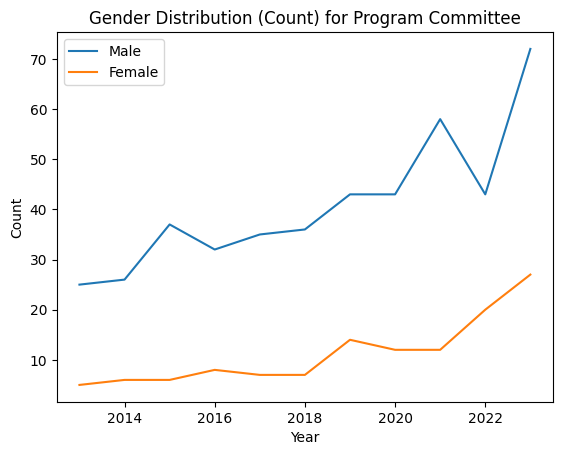

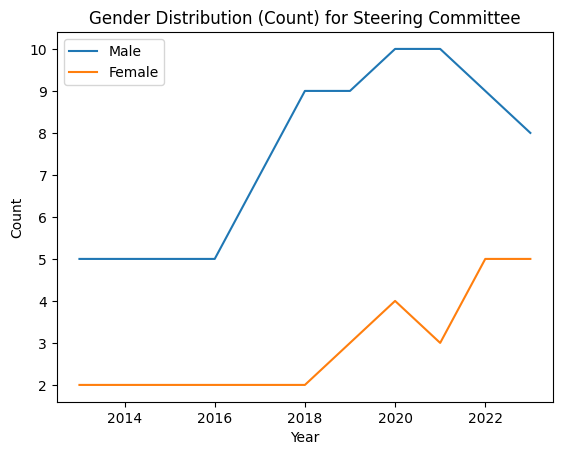

In [ ]:
# Get unique committee and year values from the DataFrame
committees = dfNSDI['committee'].unique()
years = dfNSDI['year'].unique()

# Get unique continent values from the "Continent" column
genders = dfNSDI['Gender'].unique()

# Create separate line graphs for each committee
for committee in committees:
    # Create a figure and axis for the current committee
    fig, ax = plt.subplots()

    # Loop through each continent
    for gender in genders:
        # Create an empty list to store the counts for each year
        counts = []

        # Loop through each year
        for year in years:
            # Filter the DataFrame for the current committee, continent, and year
            df_filtered = dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['Gender'] == gender) & (dfNSDI['year'] == year)]

            # Get the count of members for the current continent and year
            count = len(df_filtered)

            # Append the count to the list
            counts.append(count)

        # Plot the counts as a line graph for the current continent
        ax.plot(years, counts, label=gender)

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.set_title(f'Gender Distribution (Count) for {committee} Committee')
    ax.legend()

    # Display the plot
    plt.show()

Making graphs showing the changes of geographic distribution (as a percentage and as a count) for each of the two committee types over the entire time span.

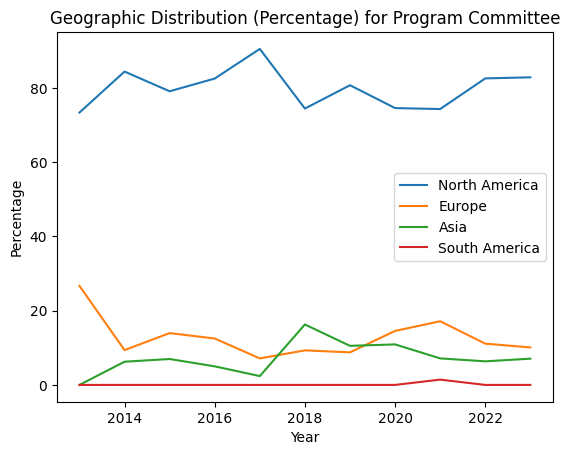

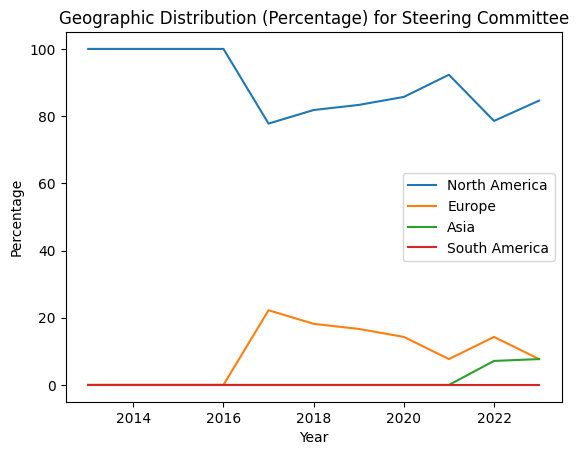

In [ ]:
# Get unique committee and year values from the DataFrame
committees = dfNSDI['committee'].unique()
years = dfNSDI['year'].unique()

# Get unique continent values from the "Continent" column
continents = dfNSDI['Continent'].unique()

# Create separate line graphs for each committee
for committee in committees:
    # Create a figure and axis for the current committee
    fig, ax = plt.subplots()

    # Loop through each continent
    for continent in continents:
        # Create an empty list to store the percentages for each year
        percentages = []

        # Loop through each year
        for year in years:
            # Filter the DataFrame for the current committee, continent, and year
            df_filtered = dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['Continent'] == continent) & (dfNSDI['year'] == year)]

            # Get the count of members for the current continent and year
            count = len(df_filtered)

            # Calculate the percentage by dividing the count by the total count for the committee and year
            total_count = len(dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['year'] == year)])
            percentage = (count / total_count) * 100

            # Append the percentage to the list
            percentages.append(percentage)

        # Plot the percentages as a line graph for the current continent
        ax.plot(years, percentages, label=continent)

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Geographic Distribution (Percentage) for {committee} Committee')
    ax.legend()

    # Display the plot
    plt.show()

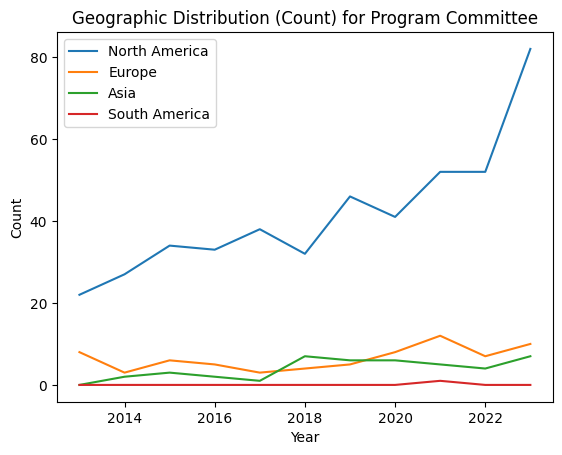

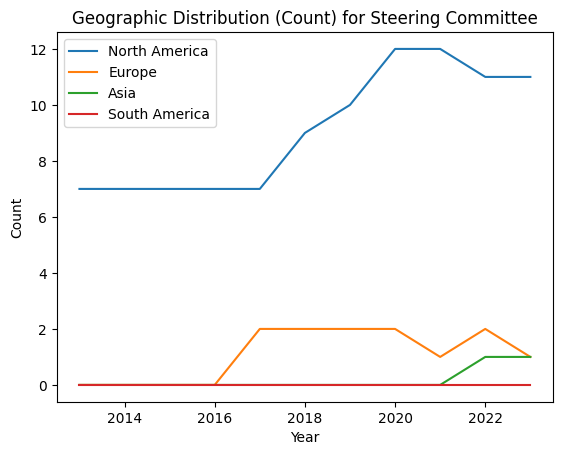

In [ ]:
# Get unique committee and year values from the DataFrame
committees = dfNSDI['committee'].unique()
years = dfNSDI['year'].unique()

# Get unique continent values from the "Continent" column
continents = dfNSDI['Continent'].unique()

# Create separate line graphs for each committee
for committee in committees:
    # Create a figure and axis for the current committee
    fig, ax = plt.subplots()

    # Loop through each continent
    for continent in continents:
        # Create an empty list to store the counts for each year
        counts = []

        # Loop through each year
        for year in years:
            # Filter the DataFrame for the current committee, continent, and year
            df_filtered = dfNSDI[(dfNSDI['committee'] == committee) & (dfNSDI['Continent'] == continent) & (dfNSDI['year'] == year)]

            # Get the count of members for the current continent and year
            count = len(df_filtered)

            # Append the count to the list
            counts.append(count)

        # Plot the counts as a line graph for the current continent
        ax.plot(years, counts, label=continent)

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.set_title(f'Geographic Distribution (Count) for {committee} Committee')
    ax.legend()

    # Display the plot
    plt.show()